In [ ]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00


In [ ]:
from astroquery.gaia import Gaia
import pandas as pd
import numpy as np

In [ ]:
test_query = "SELECT TOP 10 source_id, ra, dec FROM gaiadr3.gaia_source"
job = Gaia.launch_job_async(test_query, dump_to_file=False)
print(job.get_results())

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
  source_id            ra                 dec        
                      deg                 deg        
-------------- ------------------ -------------------
 2989297243520  45.15177931650934 0.15411389203163744
 3680787975936  45.01912373732518  0.1632369297191619
 7632157690368 45.034342834696204 0.23538959951604121
10140418622208 45.150517603186685  0.2275896915525214
11514808012928  45.26902379576179  0.2850917437974958
11613592457216  45.29390547810975  0.2772527510387779
12545600306304 45.234476460376314  0.3181518585465403
14190572136064  45.13971559547796  0.3176307911473092
14190572136192  45.13862793896008  0.3189881279787019
15255724031744  45.09627718465885  0.3445826110748102


In [ ]:
#Search Field (edit to reproduce results)
ra_center = 54 # Right Ascension in deg
dec_center = 24 # Declination in deg
radius_deg = 1 # Radius in degrees BE CAREFUL CHAGNING,5 DEG TAKES ~up to 7 MIN to RUN
# Astronomical Data Query Language to work with the data release (filters data)
query = f""" SELECT TOP 50000
  source_id, ra, dec,
  parallax, parallax_error,
  pmra, pmra_error,
  pmdec, pmdec_error,
  phot_g_mean_mag, bp_rp,
  ruwe, visibility_periods_used
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', {ra_center}, {dec_center}, {radius_deg}))
AND ruwe < 1.4
AND visibility_periods_used >= 10
AND parallax_over_error >= 5"""

In [ ]:
#Run the query, then convert to a Pandas Data Frame
job = Gaia.launch_job_async(query)
if job.is_finished:
    results = job.get_results()
    data_frame = results.to_pandas()
data_frame.to_csv("gaia_DR3_field.csv", index=False)
print("CSV file saved as gaia_DR3_field.csv")

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
CSV file saved as gaia_DR3_field.csv


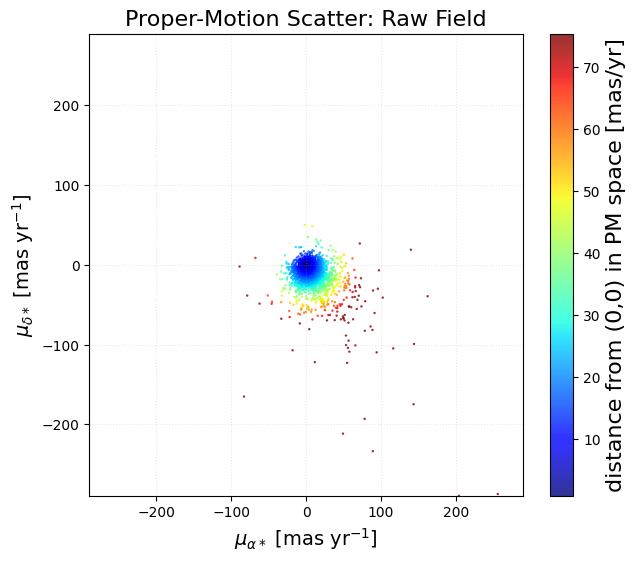

In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl

pmra = data_frame["pmra"].to_numpy()
pmdec = data_frame["pmdec"].to_numpy()
pm_dist = np.sqrt(pmra**2 + pmdec**2) #found pm distance using pythagorean theorem
norm = mpl.colors.Normalize(vmin=np.percentile(pm_dist, 1), vmax=np.percentile(pm_dist, 99))
cmap = mpl.cm.jet

plt.figure(figsize=(7, 6))
sc = plt.scatter(pmra, pmdec, c=pm_dist, cmap=cmap, s=3, alpha=0.8, edgecolors="none", norm=norm)
plt.xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]', fontsize=14) #latex for special mathematical characters
plt.ylabel(r'$\mu_{\delta*}$ [mas yr$^{-1}$]', fontsize=14)
plt.title('Proper-Motion Scatter: Raw Field', fontsize=16)

# prob obvious but in the report we should begin by explaining all the terms like proper motion, RA and Dec, etc

pm_lim = max(np.abs(pmra).max(), np.abs(pmdec).max())
plt.xlim(-pm_lim, pm_lim)
plt.ylim(-pm_lim, pm_lim)

cbar = plt.colorbar(sc)
cbar.set_label("distance from (0,0) in PM space [mas/yr]", fontsize=16)

plt.grid(True, ls=":", alpha=0.3)

plt.show()

In [ ]:
#Run DBSCAN and label members
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
df = pd.read_csv("gaia_DR3_field.csv")

#only keeps the needed features
col_need = ["pmra", "pmdec", "parallax", "parallax_error"]
#trim outliers to clean up the density scale
dfc = df.dropna(subset=col_need).copy()
dfc["parallax_over_error"] = dfc["parallax"] / dfc["parallax_error"]
#add another ruwe and magnitude cut to lower N and improve DBSCAN
dfc=dfc[(dfc["ruwe"]< 1.15) & (dfc["phot_g_mean_mag"] < 18) & (dfc["parallax_over_error"] >=5)].copy()
for c in ["pmra", "pmdec"]:
    q1, q99 = np.percentile(dfc[c], [1, 99])
    dfc = dfc[(dfc[c] >= q1) & (dfc[c] <= q99)].copy()
print(f"Rows Usable for Clustering: {len(dfc)}")

Rows Usable for Clustering: 3842


Suggested eps (standard units): ~0.590


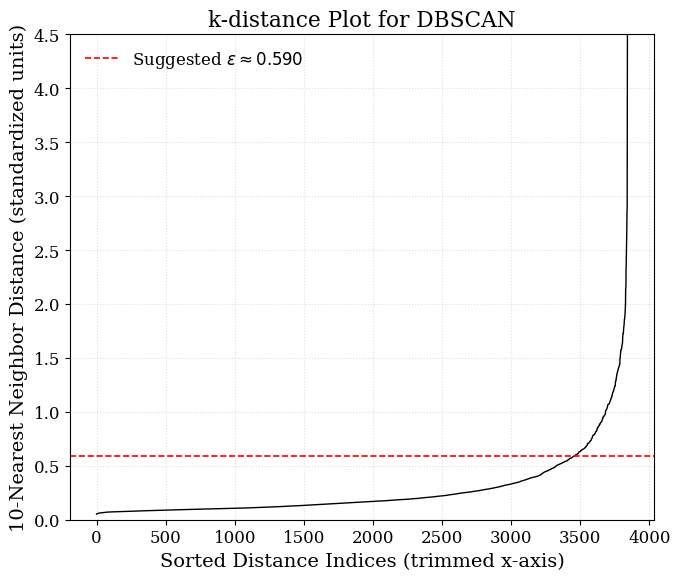

In [ ]:
#Starting with Proper motions, adding in parallax once a clump is clear in proper motion
X = dfc[["pmra", "pmdec", "parallax"]].to_numpy()
# standardize to use DBSCAN (distance-based)
scale = StandardScaler()
X_z = scale.fit_transform(X)
# Pick eps (eps(epsilon) : the max distance between two points to consider them neighbors)
minimum_samples = 10 #can be anywhere between 10 and 30
nbrs = NearestNeighbors(n_neighbors=minimum_samples).fit(X_z)
dists, _ = nbrs.kneighbors(X_z)
k_dist = np.sort(dists[:, -1]) # the distance to the kth neighbor

#auto-suggestion for eps
eps_guess = np.percentile(k_dist, 90) #85-95 percentile band
print(f"Suggested eps (standard units): ~{eps_guess:.3f}")

#plot to visualize and check
plt.rcParams.update({
    "font.size": 13,
    "font.family": "serif",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (7, 6)
})

plt.ylim(0, 4.5)
plt.xlim(auto=True)
# zoomed the graph in a little by trimming the axes, trying to improve readability and aesthetics

plt.plot(k_dist, color="black", linewidth=1)
plt.axhline(eps_guess, color="red", linestyle="--",
             linewidth=1.2, label=fr"Suggested $\epsilon \approx {eps_guess:.3f}$")
#^ will show our eps guess

plt.ylabel(f"{minimum_samples}-Nearest Neighbor Distance (standardized units)")
plt.xlabel("Sorted Distance Indices (trimmed x-axis)")
plt.title("k-distance Plot for DBSCAN")

plt.grid(True, ls=":", alpha=0.4)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
#eps guess needs to be between 0.1 and 0.7
eps = float(eps_guess) #can change manually
#run DBSCAN
db = DBSCAN(eps=eps, min_samples=minimum_samples).fit(X_z)
labels = db.fit_predict(X_z)
dfc["cluster"] = labels
print(dfc["cluster"].value_counts().head(10)) #-1 would be noise

cluster
 0    3519
-1     248
 1      44
 3      16
 2      15
Name: count, dtype: int64


In [ ]:
# Keeps only true clusters
clusters = (dfc[dfc["cluster"]>=0].groupby("cluster").agg(
    N=("cluster","size"),
    pmra_med=("pmra","median"),
    pmdec_med=("pmdec","median"),
    par_med=("parallax","median"),
    pmra_std=("pmra","std"),
    pmdec_std=("pmdec","std"),
    par_std=("parallax","std"),
    ).sort_values("N", ascending=False))
clusters["pm_sigma"] = np.hypot(clusters["pmra_std"], clusters["pmdec_std"])
print(clusters.head(10)) #edited lower to aviod crashing
#choose the best candidate
candidates = clusters[
    (clusters["N"] >= 21) & (clusters["N"] <= 2500)]

if not candidates.empty:
    candidates = candidates.sort_values(["pm_sigma", "par_std"])
    best = candidates.index[0]
    members = dfc[dfc["cluster"] == best]
    print("Chosen cluster", best, "with N =", len(members))
    print(candidates.head(5)[["N","pm_sigma","par_std"]])
else:
    members = pd.DataFrame()
    print("No suitable cluster found.")

            N   pmra_med  pmdec_med   par_med  pmra_std  pmdec_std   par_std  \
cluster                                                                        
0        3519   2.529515  -4.206907  0.851693  5.708211   5.363316  0.609917   
1          44  20.859869 -45.049548  7.333053  0.872848   1.723608  0.278657   
3          16  24.887940 -28.312712  3.150286  2.085824   2.333587  0.384254   
2          15  27.570765 -14.596283  2.001619  2.207362   1.958707  0.393783   

         pm_sigma  
cluster            
0        7.832549  
1        1.932017  
3        3.129902  
2        2.951098  
Chosen cluster 1 with N = 44
          N  pm_sigma   par_std
cluster                        
1        44  1.932017  0.278657


In [ ]:
#validation plots ie. members vs field, parallax distributions

#uncertainties


In [ ]:
#Proper motion scatter one cluster vs field
def plot_pm_cluster_v_field(df, cluster_id, label_col="cluster", s_field=4, s_mem=10, show_plot=True):
  d = df.dropna(subset=["pmra", "pmdec", label_col]).copy()
  mem = d[d[label_col] == cluster_id]
  fld = d[d[label_col] != cluster_id]

  fig, ax = plt.subplots(figsize=(7,6))
  ax.scatter(fld["pmra"], fld["pmdec"], s=s_field, alpha=0.15, color="gray", label="Field")
  ax.scatter(mem["pmra"], mem["pmdec"], s=s_mem, alpha=0.9, color="crimson", label=f"Cluster {cluster_id}")

  ax.set_xlabel(r"$\mu_{\alpha*}$  [mas yr$^{-1}$]")
  ax.set_ylabel(r"$\mu_{\delta}$  [mas yr$^{-1}$]")
  ax.set_title("Proper-Motion: Chosen Cluster vs. Field")
  ax.grid(True, ls=":", alpha=0.4)
  ax.legend(loc="best")
  if show_plot:
      plt.show()

print(dfc["cluster"].value_counts())


cluster
 0    3519
-1     248
 1      44
 3      16
 2      15
Name: count, dtype: int64


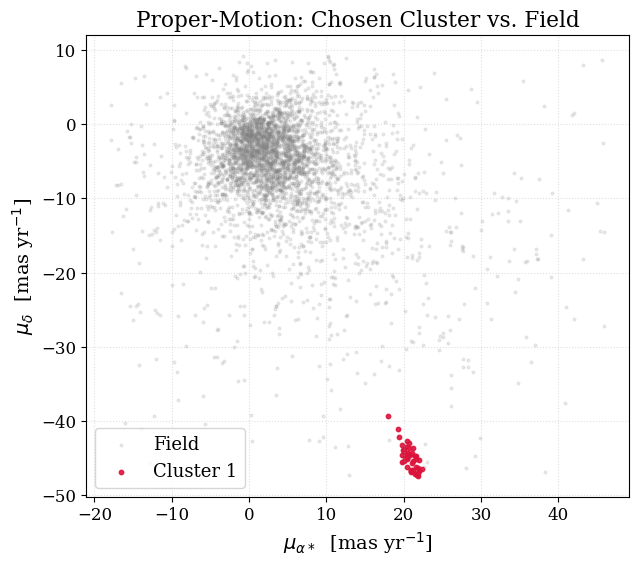

In [ ]:
plot_pm_cluster_v_field(dfc, cluster_id=best)


In [ ]:
#Parallax Distributuion Plot
def parallax_distribution_plot(df, cluster_id, label_col="cluster", bins=50, show_plot=True):
  d = df.dropna(subset=["parallax", label_col]).copy()
  mem = d[d[label_col] == cluster_id]
  fld = d[d[label_col] != cluster_id]

  fig, ax = plt.subplots(figsize=(7,5))

  #Broad distribution expected for field stars
  ax.hist(fld["parallax"], bins=bins, alpha=0.35, density=True, color="gray", label="Field Stars")

  #Narrow expected for Cluster Members
  ax.hist(mem["parallax"], bins=bins, alpha=0.85, density=True, color="crimson", label=f"Cluster {cluster_id}")
  ax.set_xlabel("Parallax [mas]")
  ax.set_ylabel("Probability Density")
  ax.set_title("Parallax Distribution: Cluster vs. Field")
  ax.grid(True, ls=":", alpha=0.4)
  ax.legend()
  if show_plot:
    plt.show()

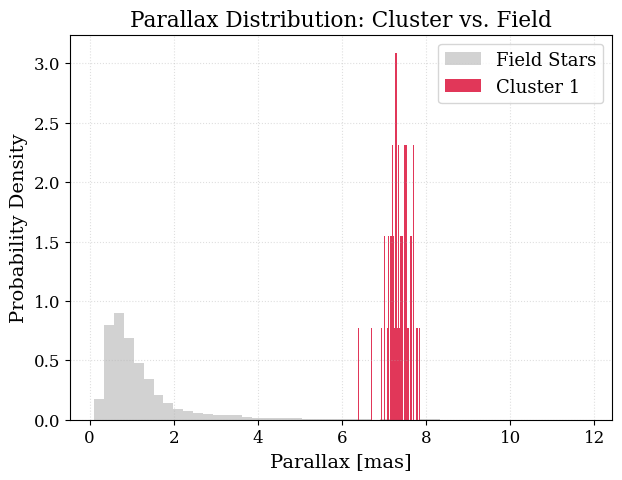

In [ ]:
parallax_distribution_plot(dfc, cluster_id=best)

In [ ]:
#Color Magnitude Diagram
def plot_cmd_cluster_vs_field(df, cluster_id=best, g_col="phot_g_mean_mag", color_col="bp_rp", label_col="cluster", s_field=4, s_mem=12, show_plot=True):
    # keep only rows with valid CMD and label
    d = df.dropna(subset=[g_col, color_col, label_col]).copy()
    mem = d[d[label_col] == cluster_id]
    fld = d[d[label_col] != cluster_id]

    fig, ax = plt.subplots(figsize=(6, 8))

    ax.scatter(
        fld[color_col], fld[g_col],
        s=s_field, alpha=0.15, color="gray", label="Field")

    ax.scatter(
        mem[color_col], mem[g_col],
        s=s_mem, alpha=0.9, color="crimson", label=f"Cluster {cluster_id}")

    ax.set_xlabel(r"$\mathrm{BP} - \mathrm{RP}$ [mag]")
    ax.set_ylabel(r"$G$ [mag]")
    ax.set_ylim(4, 18.5)
    ax.invert_yaxis()  # put the brighter stars at the top
    ax.set_title("Color–Magnitude Diagram (CMD): Cluster vs Field")
    ax.grid(True, ls=":", alpha=0.4)
    ax.legend(loc="best")

    if show_plot:
        plt.show()

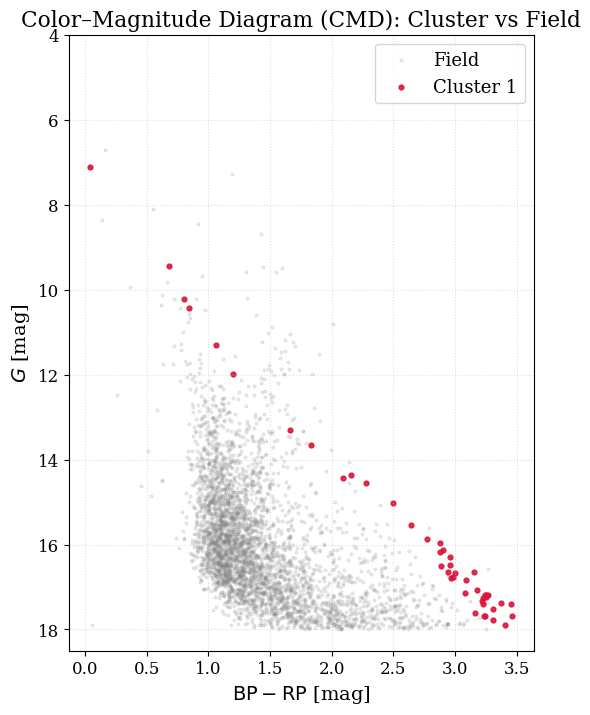

In [ ]:
plot_cmd_cluster_vs_field(dfc, cluster_id=best)

In [ ]:
#Sky Map
#real culsters have spatial overdensity
def sky_map_plot(df, cluster_id, label_col="cluster", show_plot=True):
  d = df.dropna(subset=["ra","dec",label_col]).copy()
  mem = d[d[label_col] == cluster_id]
  fld = d[d[label_col] != cluster_id]

  fig, ax = plt.subplots(figsize=(7,6))
  ax.scatter(fld["ra"], fld["dec"], s=4, alpha=0.15, color="gray")
  ax.scatter(mem["ra"], mem["dec"], s=10, alpha=0.8, color="crimson")

  ax.set_xlabel("RA [deg]")
  ax.set_ylabel("Dec [deg]")
  ax.set_title("Sky Map: Cluster vs Field")
  #increasing RA to the left
  ax.invert_xaxis()
  ax.grid(True, ls=":", alpha=0.4)

  if show_plot:
      plt.show()


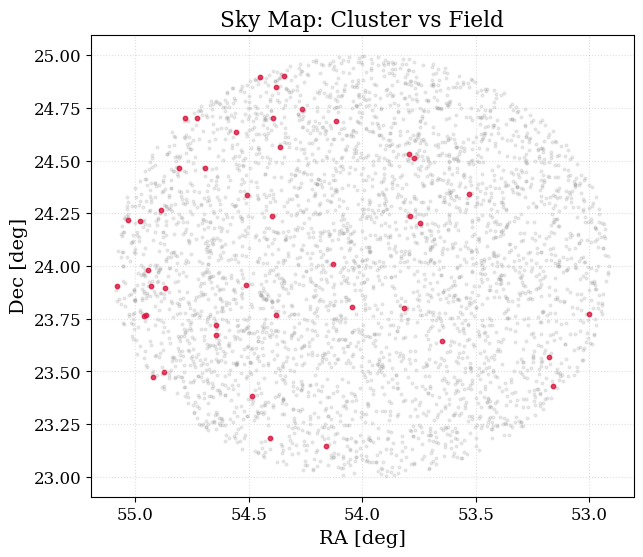

In [ ]:
sky_map_plot(dfc, cluster_id=best)

In [ ]:
#Proper Motion Vector Plot (Cluster star have a similar tangetial motion)
def plot_pm_vectors(df, cluster_id, scale=5, show_plot=True):
    mem = df[df["cluster"] == cluster_id].dropna(subset=["ra","dec","pmra","pmdec"])

    fig, ax = plt.subplots(figsize=(7,6))
    ax.quiver(mem["ra"], mem["dec"], mem["pmra"], mem["pmdec"],
              angles='xy', scale_units='xy', scale=scale, color="crimson")


    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("Dec [deg]")
    ax.set_title("Vector Proper-Motion Field")
    ax.grid(True, ls=":", alpha=0.4)

    if show_plot:
        plt.show()

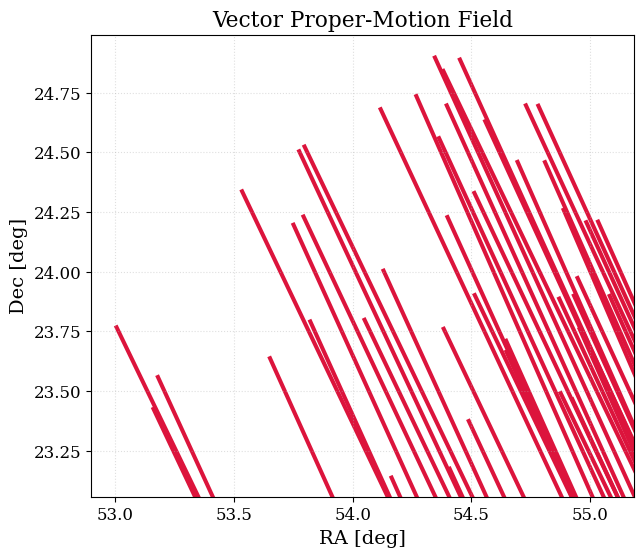

In [ ]:
plot_pm_vectors(dfc, cluster_id=best)

In [ ]:
# Signal to background surface ratio plot
def plot_pm_signal_to_background(df, cluster_id, pmra_col="pmra", pmdec_col="pmdec", label_col="cluster", nbins=15, r_max=None, show_plot=True):
  #keep only needed columns
  d = df.dropna(subset=[pmra_col, pmdec_col, label_col]).copy()

  # Separate cluster from the field
  is_cluster = (d[label_col] == cluster_id)
  cluster = d[is_cluster]
  field   = d[~is_cluster]

  if cluster.empty:
      raise ValueError(f"No stars found with {label_col} == {cluster_id}")

  # Proper-motion center: mean of the cluster members
  pmra0 = cluster[pmra_col].mean()
  pmdec0 = cluster[pmdec_col].mean()

  # Compute the radii in proper-motion space
  d["pm_r"] = np.sqrt((d[pmra_col] - pmra0)**2 + (d[pmdec_col] - pmdec0)**2)

  # Choose the max radius
  if r_max is None:
    r_max = d["pm_r"].max()

  # Radial bin edges and centers
  r_edges = np.linspace(0.0, r_max, nbins + 1)
  r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

  sigma_cluster = np.zeros(nbins)
  sigma_field   = np.zeros(nbins)
  sb_ratio      = np.zeros(nbins)
  sb_err        = np.zeros(nbins)

  # Compute counts in each annulus
  for i in range(nbins):
      r_in, r_out = r_edges[i], r_edges[i+1]
      area = np.pi * (r_out**2 - r_in**2)

      in_bin = (d["pm_r"] >= r_in) & (d["pm_r"] < r_out)
      in_cluster_bin = in_bin & is_cluster
      in_field_bin   = in_bin & (~is_cluster)

      n_cl = in_cluster_bin.sum()
      n_f  = in_field_bin.sum()

      if area <= 0:
          continue

      # Surface densities
      sigma_cluster[i] = n_cl / area
      sigma_field[i]   = n_f  / area

        # Signal/background ratio; if no background, set nan
      if n_f > 0:
          sb_ratio[i] = sigma_cluster[i] / sigma_field[i]
          # Poisson-ish error propagation
          # sigma ~ sqrt(N)/A  -> approximate fractional errors
          err_cl = np.sqrt(n_cl) / area if n_cl > 0 else 0.0
          err_f  = np.sqrt(n_f)  / area
          if sigma_cluster[i] > 0 and sigma_field[i] > 0:
              frac_err = np.sqrt(
              (err_cl / sigma_cluster[i])**2 +
              (err_f  / sigma_field[i])**2)
              sb_err[i] = sb_ratio[i] * frac_err
          else:
              sb_err[i] = 0.0
      else:
            sb_ratio[i] = np.nan
            sb_err[i]   = np.nan

    # Make the plot
  fig, ax = plt.subplots(figsize=(7, 5))

    # Plot the ratio with error bars
  ax.errorbar(
        r_centers, sb_ratio, yerr=sb_err,
        fmt="o", capsize=3
    )

  ax.axhline(1.0, linestyle="--", linewidth=1)
  ax.set_xlabel(r"Radius in proper-motion space, $r_{\mu}$ (mas yr$^{-1}$)")
  ax.set_ylabel(r"$\Sigma_{\rm cluster} / \Sigma_{\rm field}$")
  ax.set_title(f"Signal-to-background in PM space (cluster = {cluster_id})")

  ax.set_ylim(bottom=0)

  if show_plot:
        plt.show()

  return fig, r_centers, sb_ratio, sb_err


In [ ]:
def plot_cluster_std(clusters, cluster_id):
    row = clusters.loc[cluster_id]
    std_values = {"pmRA_std": row["pmra_std"], "pmDEC_std": row["pmdec_std"], "parallax_std": row["par_std"]}

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(std_values.keys(), std_values.values(), color="cornflowerblue")
    ax.set_ylabel("Standard deviation")
    ax.set_title(f"STD of cluster {cluster_id}")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    return fig

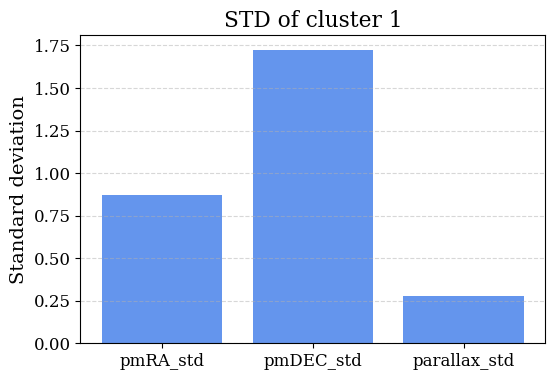

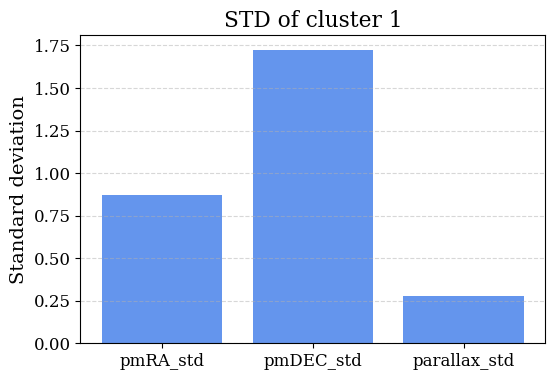

In [ ]:
plot_cluster_std(clusters, best)